<div align="center">
    <br><b><font size="6">Unmasking Fraud in Bank Account Openings - Demo 2</font></b><br><br>
</div>

In this notebook, we will dive into more **deep learning-based methods** to address fraud detection in BAF dataset.

# Outline:
<br>
<ul>
    <li><b>Dataset Preparation</b></li><br>
    <li><b>Methods</b></li>
    <ul>
        <li><b>TabNet</b></li>
        <li><b>Autoencoder</b></li>
        <li><b>ICL</b></li>
    </ul>
    <br>
    <li><b>Results</b></li><br>
</ul>

# Dataset Preparation

<p>Here, we use BAFDataset class to prepare the BAF dataset for our experiments, handling loading, train-test splitting, and preprocessing tasks in a clear and organized manner.</p>


In [1]:
# Import the necessary packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
from baf import BAFDataset
from metrics import calculate_tpr_at_fpr, calculate_fairness_metrics
import os
import joblib
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

print(os.environ)
seed = 100
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

environ({'SLURM_MPI_TYPE': 'pmi2', 'CONDA_SHLVL': '0', 'LD_LIBRARY_PATH': '/scratch/ssd001/pkgs/cudnn-11.4-v8.2.4.15/lib64:/scratch/ssd001/pkgs/cuda-11.6/targets/x86_64-linux/lib', 'CONDA_EXE': '/h/vkhazaie/anaconda3/bin/conda', 'SRUN_DEBUG': '3', 'SLURM_STEP_ID': '0', 'SLURM_STEP_GPUS': '2', 'SLURM_NODEID': '0', 'SLURM_TASK_PID': '4505', 'SSH_CONNECTION': '97.108.101.79 51253 172.17.15.236 22', 'SLURM_PRIO_PROCESS': '0', 'LANG': 'en_US.UTF-8', 'SLURM_SUBMIT_DIR': '/fs01/home/vkhazaie', 'PMI_SIZE': '1', 'OLDPWD': '/h/vkhazaie', 'SLURM_STEPID': '0', 'SLURM_SRUN_COMM_HOST': '172.17.15.236', 'SLURM_DISTRIBUTION': 'cyclic,pack', 'ROCR_VISIBLE_DEVICES': '0', 'SLURM_PROCID': '0', 'SLURM_JOB_GID': '11114', 'SLURMD_NODENAME': 'gpu097', 'VIRTUAL_ENV': '/ssd003/projects/aieng/public/anomaly_detection_environment', 'SLURM_TASKS_PER_NODE': '1', 'S_COLORS': 'auto', '_CE_M': '', 'XDG_SESSION_ID': '45822', 'SLURM_NNODES': '1', 'USER': 'vkhazaie', 'SLURM_LAUNCH_NODE_IPADDR': '172.17.15.236', 'SLURM_ST

In [2]:
# Instantiate the BAF class
ds = BAFDataset()

In [3]:
# set the path to the dataset and models

base_path = "/ssd003/projects/aieng/public/anomaly_detection_datasets/BAF"
model_path = "/ssd003/projects/aieng/public/anomaly_detection_models/BAF"

variant = "Base.csv"

In [4]:
# Add file to path
file_path = os.path.join(base_path, variant)

# Load the dataset
df = ds.load_data(file_path)

In [5]:
# Split the dataset into train and test sets
(X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

In [6]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w
96843,0.8,0.153411,-1,105,30,0.003467,-0.906840,AC,1779,1147.615990,...,1,-1,0,200.0,0,INTERNET,3.911696,linux,0,1
96844,0.8,0.442439,-1,107,40,0.021131,-1.553115,AC,1195,10788.642570,...,1,-1,0,200.0,0,INTERNET,23.696737,other,0,2
96845,0.9,0.328328,-1,79,70,0.009110,-0.801146,AC,845,8504.451753,...,1,-1,0,2000.0,0,INTERNET,2.803927,windows,0,1
96846,0.7,0.033834,-1,28,30,0.004707,-1.171706,AB,1697,6011.217859,...,1,28,0,1000.0,0,INTERNET,5.262441,windows,1,2
96847,0.9,0.150643,-1,164,40,0.012221,-0.227823,AB,1474,8378.324044,...,1,5,0,1500.0,0,INTERNET,5.728984,windows,0,1


In [7]:
# One-hot encode the categorical features in the dataset
X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

In [8]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,16,17,18,19,20,21,22,23,24,25
96843,0.8,0.153411,-1,105,30,0.003467,-0.906840,1779,1147.615990,3076.384487,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
96844,0.8,0.442439,-1,107,40,0.021131,-1.553115,1195,10788.642570,5790.128646,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
96845,0.9,0.328328,-1,79,70,0.009110,-0.801146,845,8504.451753,5912.163054,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
96846,0.7,0.033834,-1,28,30,0.004707,-1.171706,1697,6011.217859,5505.127811,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
96847,0.9,0.150643,-1,164,40,0.012221,-0.227823,1474,8378.324044,4930.672316,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# Dictionaries to store training and inference times
training_times_dict = {}
inference_times_dict = {}

# Methods

Now, let's delve into the methods employed to analyze the BAF dataset. The following section will outline the approaches and techniques used to address fraud detection in this high-stakes banking context.

## TabNet: Attentive Interpretable Tabular Learning

**TabNet** presents an innovative approach that bridges the gap between two prominent machine learning paradigms: **Decision Trees (DTs)** and **Deep Neural Networks (DNNs)**. The methodology introduced in this work combines the strengths of these two approaches to create a powerful learning framework for real-world **tabular datasets**. While **DNNs lack the transparency and interpretability of DTs**, DTs often struggle to capture the intricacies of complex patterns present in diverse tabular data. TabNet's primary contribution revolves around its meticulously designed architecture, which effectively integrates the output structure of DTs within the flexible framework of DNNs.

The central concept driving TabNet is the emulation of **decision boundaries** akin to those established by DTs. However, TabNet introduces a novel mechanism by leveraging a sequence of **learnable masks** to guide feature selection at each step. These masks, derived through the innovative **sparsemax normalization technique**, offer a dual advantage: they optimize parameter usage efficiently and promote interpretability by **highlighting the most pertinent features**. Moreover, the incorporation of **sparsity regularization** empowers the model with the ability to control the extent of feature selection, a crucial capability when dealing with datasets containing redundant or irrelevant features.

TabNet's architecture excels due to its **sequential multi-step approach**, wherein decisions are iteratively refined by progressively considering the most influential features. Inspired by applications in visual processing and reinforcement learning, the **top-down attention mechanism** equips the model to concentrate on relevant information, effectively tackling the challenges posed by high-dimensional inputs. This results in a dynamic decision process that effectively harnesses the strengths of both local and global features, thereby enhancing TabNet's proficiency in capturing intricate relationships within tabular data.

In essence, TabNet strikes a remarkable balance between **predictive power and interpretability**. Its capability to not only **outperform traditional DTs** but also provide **invaluable insights into feature importance** positions it as a potent solution for learning from tabular datasets. This becomes particularly relevant in domains where comprehending the decision-making process is just as pivotal as achieving accurate predictions.


In [10]:
# Create an instance of TabNet model
clf = TabNetClassifier()

/ssd003/projects/aieng/public/anomaly_detection_environment/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [11]:
# Create a custom metric class to pass to TabNet
class TPR_at_05FPR(Metric):
    def __init__(self):
        self._name = "tpr_at_05fpr"
        self._maximize = True

    def __call__(self, y_true, y_score):
        fpr, tpr, threshold = roc_curve(y_true, y_score[:, 1])
        tpr_at_05fpr = tpr[fpr < 0.05][-1]
        return tpr_at_05fpr

Set 1 for automatic weight balancing or try different values and see how the performance changes.

In [12]:
# Start measuring training time
start_time = time.time()

# Train TabNet
clf.fit(
    X_train.values, 
    y_train.values,
    eval_metric=[TPR_at_05FPR, "auc"],
    max_epochs=5,
    batch_size=512,
    weights=0
)

# End measuring training time
end_time = time.time()

# Storing and printing the time
tabnet_training_time = end_time - start_time
print(f"Training Time: {tabnet_training_time} seconds")
training_times_dict[(variant.split('.')[0], "TabNet")] = {"Training Time":tabnet_training_time}

/ssd003/projects/aieng/public/anomaly_detection_environment/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.05198 |  0:00:59s
epoch 1  | loss: 0.04631 |  0:01:58s
epoch 2  | loss: 0.04549 |  0:02:56s
epoch 3  | loss: 0.04523 |  0:03:55s
epoch 4  | loss: 0.04475 |  0:04:54s
Training Time: 629.1139430999756 seconds


In [13]:
# Start measuring inference time
start_time = time.time()

# Predict on the test set
tabnet_scored_test = clf.predict_proba(X_test.values)[:,1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
tabnet_inference_time = end_time - start_time
print(f"Inference Time: {tabnet_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "TabNet")] = {"Inference Time":tabnet_inference_time}

Inference Time: 6.193806409835815 seconds


If you want to save the model, you can use:

```python
clf.save_model("PATH_TO_SAVE_MODEL")
```

In [14]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, tabnet_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'TabNet')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5069, Model FPR: 0.05, Model Threshold: 0.028200000524520874, Model AUROC: 0.8822


In [15]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, tabnet_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'TabNet')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Fairness Ratio: 0.3459 



## Autoencoder

Now we want to apply some unsupervised methods for anomaly detection. In this cell, we begin by importing essential libraries required for building and training neural networks, as well as for data preprocessing and evaluation. We also import Scikit-learn libraries for metrics calculation and data scaling.

Following the imports, we define the architecture of the autoencoder model. An autoencoder is a type of neural network consisting of an encoder and a decoder. The purpose of an autoencoder is to learn a compressed representation of input data and then reconstruct the original data from this representation.

We create the `Autoencoder` class as a subclass of `nn.Module`, which is PyTorch's base class for defining neural network modules. The class includes methods for initializing the architecture and performing forward passes.

The encoder is structured using `nn.Sequential`, which is a convenient way to define a sequence of layers. It starts with a linear layer that reduces the input data's dimensionality to the specified `hidden_size`, followed by a rectified linear unit (ReLU) activation function to introduce non-linearity.

The decoder, resembling the encoder but in reverse order, takes the encoded representation and aims to reconstruct the original input data. The simplicity of this architecture allows for easy experimentation with various configurations and layer sizes.

In [16]:
# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In this cell, we set the hyperparameters that will govern the training process of the autoencoder. Hyperparameters are configuration choices that influence the behavior of the neural network during training. It's important to choose appropriate hyperparameters to ensure effective learning and convergence.

We define the `input_size` as the number of features in the input data and `hidden_size` as the number of neurons in the hidden layer of the autoencoder. These values can be adjusted based on the complexity of your data and the desired capacity of the model.

Other hyperparameters include the `batch_size`, which determines the number of data samples processed in each training iteration, the `learning_rate`, which controls the step size during optimization, and the `num_epochs`, which specifies the number of times the entire training dataset is passed through the model.

With the hyperparameters set, we create an instance of the `Autoencoder` class that we defined earlier. This instance represents our neural network model, which will be trained to learn a compressed representation of the input data.

We also define the loss function and optimizer. The loss function (`nn.MSELoss()`) calculates the mean squared error between the reconstructed data and the original data. The optimizer (`optim.Adam()`) implements the Adam optimization algorithm, which updates the model's parameters to minimize the loss during training.


In [17]:
# Hyperparameters
input_size = 50  # Number of input features
hidden_size = 30  # Number of neurons in the hidden layer
batch_size = 512
learning_rate = 0.0001
num_epochs = 5

# Create an instance of the Autoencoder
autoencoder = Autoencoder(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In this cell, we convert the DataFrames to PyTorch tensors using the `torch.tensor` function. This conversion prepares the data for feeding into the neural network model.

With the data in the form of PyTorch tensors, we are now ready to proceed with training the autoencoder model in subsequent cells.

In [18]:
# Convert DataFrame to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In this cell, we begin the training process of the autoencoder neural network. Training a neural network involves iteratively adjusting its parameters to minimize a chosen loss function and improve its performance on the given data.

We create a `train_dataset` using the scaled training data, and a `train_dataloader` using `TensorDataset` and `DataLoader` from PyTorch. The dataloader allows us to efficiently iterate over batches of data during training.

We initiate a loop that runs for a specified number of epochs. In each epoch, the autoencoder processes batches of training data through the network and updates its parameters to reduce the loss. The loss is calculated using the mean squared error (`MSELoss`) between the input data and the reconstructed output.

The `optimizer` then applies gradient descent to adjust the neural network's weights and biases, moving in the direction that minimizes the loss. This process iterates over multiple epochs, gradually improving the autoencoder's ability to capture useful features and create a compressed representation of the data.

At the end of each epoch, we print the loss to monitor the training progress and observe how it decreases over time. This cell establishes the core training loop, and the subsequent cells will focus on evaluating the trained autoencoder's performance and analyzing its results.


In [19]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Start measuring training time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch[0])
        loss = criterion(outputs, batch[0])
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# End measuring training time
end_time = time.time()

# Storing and printing the time
ae_training_time = end_time - start_time
print(f"Training Time: {ae_training_time} seconds")
training_times_dict[(variant.split('.')[0], "AE")] = {"Training Time":ae_training_time}

Epoch [1/5], Loss: 109621.1641
Epoch [2/5], Loss: 49789.3008
Epoch [3/5], Loss: 15754.1221
Epoch [4/5], Loss: 4542.7529
Epoch [5/5], Loss: 708.6297
Training Time: 43.945231914520264 seconds


In this cell, we evaluate the performance of the trained autoencoder for anomaly detection on the test data. Anomaly detection involves identifying instances that significantly deviate from the norm in the dataset.

We pass the scaled test data through the trained autoencoder's decoder to obtain reconstructed data. The difference between the original test data and the reconstructed data is used to calculate the reconstruction errors. These errors represent how well the autoencoder is able to recreate the input data.

To calculate the reconstruction errors, we use the mean squared error (`MSELoss`) with the reduction set to `'none'`. This means that the reconstruction error is computed for each individual data point without aggregating.

In [20]:
# Start measuring inference time
start_time = time.time()

# Pass the test data through the autoencoder
with torch.no_grad():
    reconstructed_data = autoencoder(X_test_tensor)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
ae_inference_time = end_time - start_time
print(f"Inference Time: {ae_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "AE")] = {"Inference Time":ae_inference_time}

# Calculate reconstruction errors
reconstruction_errors = ((reconstructed_data - X_test_tensor)**2).mean(dim=1)

# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test.values, reconstruction_errors.numpy(), fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'AE')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, reconstruction_errors.numpy(), X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'AE')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Inference Time: 0.13280272483825684 seconds
Model TPR: 0.0653, Model FPR: 0.0498, Model Threshold: 2304.104736328125, Model AUROC: 0.6174
Fairness Ratio: 0.3826 



## DeepOD: Deep Learning-Based Anomaly Detection Framework

DeepOD is an open-source Python framework designed for deep learning-based anomaly detection. It offers a unified implementation of various detection models based on PyTorch.

DeepOD currently encompasses 13 deep anomaly detection algorithms in the unsupervised and weakly-supervised paradigms. The framework provides a platform for easy experimentation with these models, and additional baseline algorithms will be incorporated in the future.

**Detection Models:**

The following detection models are included in DeepOD:

| Model       | Venue | Year | Type            | Title
|-------------|-------|------|-----------------|----------------------------------------------------
| Deep SVDD   | ICML  | 2018 | Unsupervised    | Deep One-Class Classification
| REPEN       | KDD   | 2018 | Unsupervised    | Learning Representations of Ultrahigh-dimensional Data for Random Distance-based Outlier Detection
| RDP         | IJCAI | 2020 | Unsupervised    | Unsupervised Representation Learning by Predicting Random Distances
| RCA         | IJCAI | 2021 | Unsupervised    | RCA: A Deep Collaborative Autoencoder Approach for Anomaly Detection
| GOAD        | ICLR  | 2020 | Unsupervised    | Classification-Based Anomaly Detection for General Data
| NeuTraL     | ICML  | 2021 | Unsupervised    | Neural Transformation Learning for Deep Anomaly Detection Beyond Images
| ICL         | ICLR  | 2022 | Unsupervised    | Anomaly Detection for Tabular Data with Internal Contrastive Learning
| DIF         | TKDE  | 2023 | Unsupervised    | Deep Isolation Forest for Anomaly Detection
| SLAD        | ICML  | 2023 | Unsupervised    | Fascinating Supervisory Signals and Where to Find Them: Deep Anomaly Detection with Scale Learning
| DevNet      | KDD   | 2019 | Weakly-Supervised | Deep Anomaly Detection with Deviation Networks
| PReNet      | KDD   | 2023 | Weakly-Supervised | Deep Weakly-supervised Anomaly Detection
| Deep SAD    | ICLR  | 2020 | Weakly-Supervised | Deep Semi-Supervised Anomaly Detection
| FeaWAD      | TNNLS | 2021 | Weakly-Supervised | Feature Encoding with AutoEncoders for Weakly-supervised Anomaly Detection

**Usage Examples:**

DeepOD is user-friendly and can be employed with only a few lines of code. The API style is similar to sklearn and [PyOD](https://github.com/yzhao062/pyod).

```python
# Unsupservised methods
from deepod.models.dsvdd import DeepSVDD
clf = DeepSVDD()
clf.fit(X_train, y=None)
scores = clf.decision_function(X_test)

# Weakly-supervised methods
from deepod.models.devnet import DevNet
clf = DevNet()
clf.fit(X_train, y=semi_y)  # semi_y uses 1 for known anomalies and 0 for unlabeled data
scores = clf.decision_function(X_test)


## ICL: Anomaly Detection for Tabular Data with Internal Contrastive Learning

The **ICL method** focuses on **out-of-class sample detection** in **tabular data**, where the data structure is largely unknown. It aims to **capture the structure** of single training class samples by learning mappings that **maximize the mutual information** between each sample and the **masked-out portion**. This is accomplished through a **contrastive loss**, learning mappings individually for each sample. The score for a test sample is determined by measuring the **contrastive loss of the learned mappings applied to the masked parts** of the sample. ICL **outperforms existing methods** with a substantial accuracy advantage across benchmarks.


**Contrastive learning**, rooted in metric learning and unsupervised representation learning, maximizes similarity between queries and positive samples while minimizing it with negative samples. Existing methods, often using image transformations, **don't apply to tabular data** due to the absence of invariant transformation groups. Qiu et al.'s NeuTraL AD work is a similar method for tabular data but **differs significantly**, utilizing specific masks and single feature extractors.


ICL employs a training set of in-class samples and aims to design a **scoring function** that maps samples to low values if they belong to the same distribution and high values otherwise. Hyperparameters include **k for feature subset size, u for embedding size, and τ for loss temperature**. The method **constructs pairs from each sample and learns mappings to maximize mutual information**. Mutual information maximization is achieved through the **noise contrastive estimation framework**.

In [21]:
from deepod.models.icl import ICL

In [22]:
# unsupervised method
clf = ICL(epochs=5)

In [23]:
# Start measuring training time
start_time = time.time()

# Train ICL
clf.fit(X_train.values, y=None)

# End measuring training time
end_time = time.time()

# Storing and printing the time
icl_training_time = end_time - start_time
print(f"Training Time: {icl_training_time} seconds")

Start Training...
ensemble size: 2
kernel size: 10
ICLNet(
  (enc_f_net): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=40, out_features=100, bias=False)
        (act_layer): Tanh()
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (1): LinearBlock(
        (linear): Linear(in_features=100, out_features=50, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (2): LinearBlock(
        (linear): Linear(in_features=50, out_features=128, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
    )
  )
  (enc_g_net): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=10, out_features=50, bias=

testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12422/12422 [00:37<00:00, 334.43it/s]


Training Time: 965.2103323936462 seconds


In [24]:
# Start measuring inference time
start_time = time.time()

# Predict on the test set
icl_scored_test = clf.decision_function(X_test.values)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
icl_inference_time = end_time - start_time
print(f"Inference Time: {icl_inference_time} seconds")

testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3204/3204 [00:09<00:00, 342.52it/s]


Inference Time: 19.250097274780273 seconds


If you want to save the model, you can use:

```python
torch.save(clf.net.state_dict(), "PATH_TO_SAVE_MODEL")
```

In [25]:
training_times_dict[(variant.split('.')[0], "ICL")] = {"Training Time":icl_training_time}
inference_times_dict[(variant.split('.')[0], "ICL")] = {"Inference Time":icl_inference_time}

In [26]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, icl_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'ICL')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.0865, Model FPR: 0.0499, Model Threshold: 3.1268, Model AUROC: 0.6172


In [27]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, icl_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'ICL')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Fairness Ratio: 0.9953 



# Results

In the forthcoming section, we will present the results obtained from our comprehensive analysis. We will showcase the performance metrics of the evaluated models on the BAF dataset, delving into their effectiveness in detecting fraudulent online bank account opening applications. Moreover, we will explore the fairness metrics, ensuring unbiased decision-making in the context of different user groups. To assess the real-world applicability of the models, we will provide insights into their training and inference times, offering valuable insights into their efficiency and suitability for practical use.

## Table

Below you can see all the result in one table:

In [28]:
# Create a DataFrame from all results
df_performance_results = pd.DataFrame(performance_results).transpose()
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_training_times_dict = pd.DataFrame(training_times_dict).transpose()
df_inference_times_dict = pd.DataFrame(inference_times_dict).transpose()

In [29]:
# concatenate all results together
all_results = pd.concat([df_performance_results, df_fairness_results, df_training_times_dict, df_inference_times_dict], axis=1)

In [30]:
all_results

TPR     FPR    Threshold   AUROC  Fairness Ratio  \
Base TabNet  0.5069  0.0500     0.028200  0.8822          0.3459   
     AE      0.0653  0.0498  2304.104736  0.6174          0.3826   
     ICL     0.0865  0.0499     3.126800  0.6172          0.9953   

             Training Time  Inference Time  
Base TabNet     629.113943        6.193806  
     AE          43.945232        0.132803  
     ICL        965.210332       19.250097

## Plots

The following is 4 plots demonstrating all results for all models:

In [31]:
# Extract TPR values
tabnet_tpr = df_performance_results.loc[(variant.split('.')[0], 'TabNet'), 'TPR']
ae_tpr = df_performance_results.loc[(variant.split('.')[0], 'AE'), 'TPR']
icl_tpr = df_performance_results.loc[(variant.split('.')[0], 'ICL'), 'TPR']
tpr_values = [tabnet_tpr, ae_tpr, icl_tpr]

In [32]:
# Extract Fairness Ratio values
tabnet_fn = df_fairness_results.loc[(variant.split('.')[0], 'TabNet'), 'Fairness Ratio']
ae_fn = df_fairness_results.loc[(variant.split('.')[0], 'AE'), 'Fairness Ratio']
icl_fn = df_fairness_results.loc[(variant.split('.')[0], 'ICL'), 'Fairness Ratio']
fn_values = [tabnet_fn, ae_fn, icl_fn]

In [33]:
# Extract Training Time values
tabnet_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'TabNet'), 'Training Time']
ae_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'AE'), 'Training Time']
icl_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'ICL'), 'Training Time']
tnt_values = [tabnet_tnt, ae_tnt, icl_tnt]

In [34]:
# Extract Inference Time values
tabnet_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'TabNet'), 'Inference Time']
ae_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'AE'), 'Inference Time']
icl_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'ICL'), 'Inference Time']
inf_values = [tabnet_inf, ae_inf, icl_inf]

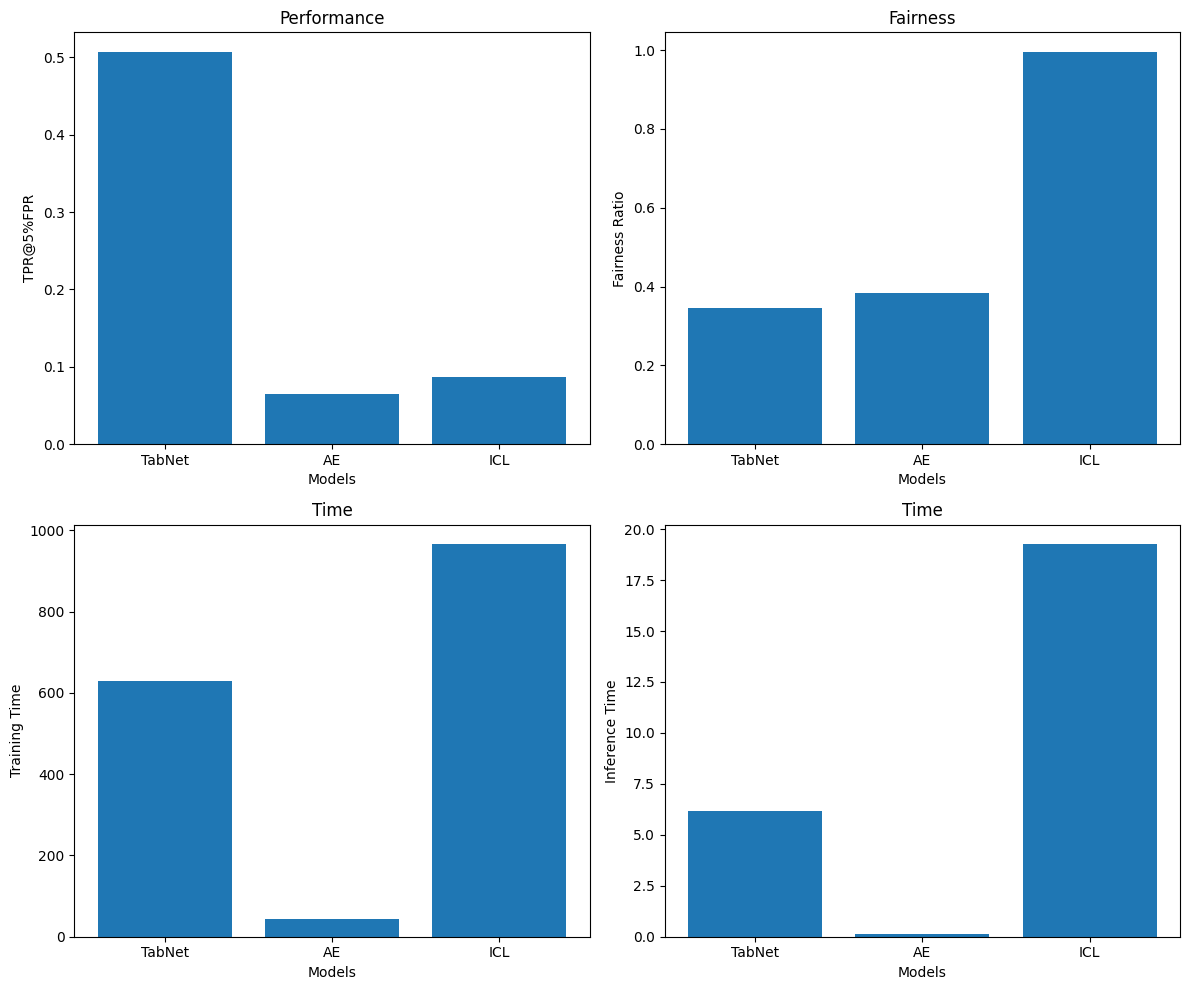

In [35]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

models = ['TabNet', 'AE', 'ICL']

# Plot TPR values
axs[0, 0].bar(models, tpr_values)
axs[0, 0].set_xlabel('Models')
axs[0, 0].set_ylabel('TPR@5%FPR')
axs[0, 0].set_title('Performance')

# Plot Fairness Ratio values
axs[0, 1].bar(models, fn_values)
axs[0, 1].set_xlabel('Models')
axs[0, 1].set_ylabel('Fairness Ratio')
axs[0, 1].set_title('Fairness')

# Plot Training Time values
axs[1, 0].bar(models, tnt_values)
axs[1, 0].set_xlabel('Models')
axs[1, 0].set_ylabel('Training Time')
axs[1, 0].set_title('Time')

# Plot Inference Time values
axs[1, 1].bar(models, inf_values)
axs[1, 1].set_xlabel('Models')
axs[1, 1].set_ylabel('Inference Time')
axs[1, 1].set_title('Time')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

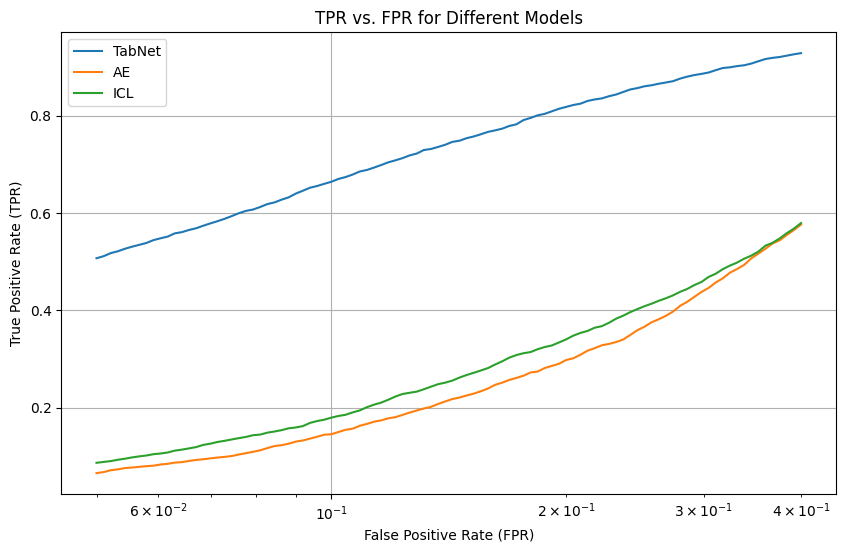

In [36]:
# Define the list of model names and their corresponding y_scores
model_names = ['TabNet', 'AE', 'ICL']
y_scores_dict = {
    'TabNet': tabnet_scored_test,
    'AE': reconstruction_errors.numpy(),
    'ICL': icl_scored_test,
}

# Generate FPR values from 5% to 40%
fpr_values = np.logspace(np.log10(0.05), np.log10(0.4), num=100)

# Initialize a dictionary to store interpolated TPR values for each model
interpolated_tpr = {}

# Calculate TPR values for each model at the desired FPR points
for model_name in model_names:
    scored_test = y_scores_dict[model_name]
    tpr_list = [calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=i)['TPR'] for i in fpr_values]
    interpolated_tpr[model_name] = tpr_list

# Plotting
plt.figure(figsize=(10, 6))
for model_name, model_tpr_interp in interpolated_tpr.items():
    plt.plot(fpr_values, model_tpr_interp, label=model_name)

plt.xscale('log')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR vs. FPR for Different Models')
plt.legend()
plt.grid(True)
plt.show()

# References:





<ul>
    <li>Jesus S, Pombal J, Alves D, Cruz A, Saleiro P, Ribeiro R, Gama J, Bizarro P. Turning the tables: Biased, imbalanced, dynamic tabular datasets for ml evaluation. Advances in Neural Information Processing Systems. 2022 Dec 6;35:33563-75.</li>

</ul>